In [9]:
import torch

from models.unet3d.model import BUNet3D,UNet3D

import os 
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [10]:
UNET = True
CKPT_DIR = "/media/hdd/viscent/SR-UNet/output_vanilla_1024_t1/checkpoints/fold_0/410.pth"

if not UNET:
    model = BUNet3D(in_channels=1,
            out_channels=1,
            f_maps=[16, 32, 64, 128, 256],
            layer_order='gcr',
            num_groups=8,
            is_segmentation=False,
            latent_size=1024,
            alpha=0.00025,
            )
else:
    model = UNet3D(in_channels=1,
            out_channels=1,
            f_maps=[16, 32, 64, 128, 256],
            layer_order='gcr',
            num_groups=8,
            is_segmentation=False,
    )
ckpt = torch.load(CKPT_DIR)
if ckpt.get('model') is None:
    state_dict = ckpt['state_dict']
    _state_dict = {}
    for key in state_dict.keys():
        _state_dict[key.replace("model.","")] = state_dict[key]
    model.load_state_dict(_state_dict)
else:
    model.load_state_dict(ckpt["model"])

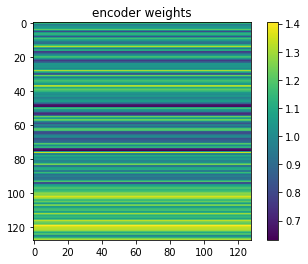

In [11]:
encoder_weights = next(model.encoders[-1].parameters())
encoder_weights = encoder_weights.cpu().detach().numpy()
encoder_weights= np.expand_dims(encoder_weights,axis=1)
encoder_weights = np.repeat(encoder_weights, 128, axis=1)
if not UNET:
    fig,(ax1,ax2) = plt.subplots(1,2)
    im1 = ax1.imshow(encoder_weights)
    ax1.set_title("encoder weights")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax=cax, orientation="vertical")

    latent_weights = next(model.mu.parameters())
    latent_weights = latent_weights.cpu().detach().numpy()
    latent_weights = np.repeat(latent_weights, 128, axis=1)

    im2 = ax2.imshow(encoder_weights)
    ax2.set_title("latent weights")
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, cax=cax, orientation="vertical")
    fig.show()
else:
    fig = plt.imshow(encoder_weights)
    plt.title("encoder weights")
    plt.colorbar()
    plt.show()

In [12]:
image = sitk.ReadImage("/media/hdd/viscent/SR-UNet/unet_image.nii")
target = sitk.ReadImage("/media/hdd/viscent/SR-UNet/unet_target.nii")
image_array = sitk.GetArrayFromImage(image)
target_array = sitk.GetArrayFromImage(target)
image_tensor = torch.tensor(image_array).unsqueeze(0).unsqueeze(0)
target_tensor = torch.tensor(target_array).unsqueeze(0).unsqueeze(0)

In [13]:
torch.cuda.set_device(0)
model.cuda()
model.train()
image_tensor = image_tensor.cuda()
target_tensor = target_tensor.cuda()
output = model(image_tensor)


In [14]:
im = image_tensor
im_hat=target_tensor
mse = torch.nn.MSELoss()(im, im_hat)
print('mse:', mse.cpu().detach().numpy())
if not UNET:
    mu, logvar = model.enc_mu, model.enc_logvar
    kl = 0.5 * (logvar.exp() + mu**2 - 1 - logvar)
    kl = torch.sum(kl)
    FE_simple = mse + 0.00025 * kl
    print('kl:', kl.cpu().detach().numpy())
    print('Free energy:', FE_simple.cpu().detach().numpy())

mse: 0.0060325894


In [15]:
output_array = output.cpu().detach().numpy()
import SimpleITK as sitk
output_image=sitk.GetImageFromArray(output_array)
sitk.WriteImage(output_image,"/media/hdd/viscent/SR-UNet/"+input("File prefix: ")+"_output.nii")

Image


Text(0.5, 1.0, 'Image')

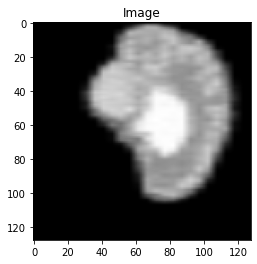

In [19]:
import matplotlib.pyplot as plt
print("Image")
plt.imshow(image_array[40,...],cmap='gray')
plt.title("Image")

Output


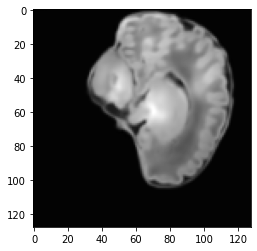

In [17]:
print("Output")
plt.imshow(output_array[0,0,40,...],cmap='gray')
plt.title("Output")

Target


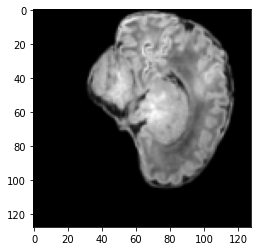

In [18]:
print("Target")
plt.imshow(target_array[40,...],cmap='gray')
plt.title("Target")